# CGAN预测落点

## 导包

In [1]:
from sklearn.utils import resample
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import itertools
import time
from torchvision import utils
import torchvision.utils as vutils

## 数据预处理

In [2]:
# 坐标系变换
def transform_coordinates(df):
    df['tMouse_X'] = df['tMouse_X'] - (df['RectLeft'] + df['TargetWidth'] / 2)
    df['Mouse_Y'] = -(df['Mouse_Y'] - (df['RectTop'] + df['TargetWidth'] / 2))

    angle_rad = np.deg2rad(-df['DirectionAngle'])
    tmpX = df['tMouse_X'] * np.cos(angle_rad) - df['Mouse_Y'] * np.sin(angle_rad)
    tmpY = df['tMouse_X'] * np.sin(angle_rad) + df['Mouse_Y'] * np.cos(angle_rad)
    
    df['tMouse_X'] = tmpX
    df['Mouse_Y'] = tmpY
    
    return df

# 去离群值
def clear_iso(df):
    
    mean_y = df['Mouse_Y'].mean()
    std_y = df['Mouse_Y'].std()
    mean_x = df['tMouse_X'].mean()
    std_x = df['tMouse_X'].std()
    df = df[(df['tMouse_X'] > mean_y - 3 * std_y) & (df['tMouse_X'] < mean_y + 3 * std_y)]
    df = df[(df['Mouse_Y'] > mean_x - 3 * std_x) & (df['Mouse_Y'] < mean_x + 3 * std_x)]
    return df

# 将落点平移到第一象限
def translation(df):
    df['tMouse_X'] -= df['tMouse_X'].min()
    df['Mouse_Y'] -= df['Mouse_Y'].min()
    return df

# 将落点居中
def centering(df, target_center_X, target_center_Y):
    current_center_X = df['tMouse_X'].mean()
    current_center_Y = df['Mouse_Y'].mean()
    offset_X = target_center_X - current_center_X
    offset_Y = target_center_Y - current_center_Y
    df['tMouse_X'] += offset_X 
    df['Mouse_Y'] += offset_Y
    return df

# 获取采样后图形，目前为np.array格式
def data_augmentation(df, width, velocity, repetitions, fraction):
    filterdata = df[(df['TargetWidth'] == width) & (df['Velocity'] == velocity)]
    filterdata = clear_iso(filterdata)
    images = []
    for _ in range(repetitions):
        sampledata = filterdata.sample(frac=fraction, replace=False)
        sampledata = translation(sampledata)
        sampledata = centering(sampledata, 128, 128)
        image = np.zeros((256, 256), dtype=float)
        for _, row in sampledata.iterrows():
            x, y = int(row['tMouse_X']), int(row['Mouse_Y'])\
            # 暂时先不考虑点重合的问题
            image[y][x] = 1
        images.append(image)
    return images

# 获取目标图像
def get_target(width, velocity):
    image = np.zeros((256, 256), dtype=float)
    center_y, center_x = 128, 128
    for y in range(256):
        for x in range(256):
            # 计算当前点到圆心的距离
            distance = np.sqrt((center_x - x) ** 2 + (center_y - y) ** 2)
            
            # 如果距离接近半径width（可以设定一个小的容忍范围，比如±1）
            if np.abs(distance - width) <= 1:
                image[y][x]= velocity
    return image

def visualize_samples(dataset, widths, velocities):
    fig, axs = plt.subplots(len(widths) * len(velocities), 2, figsize=(10, 5 * len(widths) * len(velocities)))

    for i, (width, velocity) in enumerate(itertools.product(widths, velocities)):
        for j in range(len(dataset)):
            image, condition = dataset[j]
            current_condition = get_target(width, velocity)
            if np.array_equal(condition.squeeze().numpy(), current_condition):
                axs[i, 0].imshow(image.squeeze().numpy(), cmap='gray')  # 显示图像
                axs[i, 0].set_title(f"Image - Width: {width}, Velocity: {velocity}")
                axs[i, 0].axis('off')

                axs[i, 1].imshow(condition.squeeze().numpy(), cmap='gray')  # 显示条件图
                axs[i, 1].set_title(f"Condition - Width: {width}, Velocity: {velocity}")
                axs[i, 1].axis('off')
                break
    plt.tight_layout()
    plt.show()

In [3]:
data_path = "data/total_mouse.csv"
data = pd.read_csv(data_path)
data = transform_coordinates(data)

In [4]:
class PointDataset(Dataset):
    def __init__(self, data, widths, velocities, repetition, fraction):
        self.data_pairs = []

        for width, velocity in itertools.product(widths, velocities):
            dataset = data_augmentation(data, width, velocity, repetition, fraction)
            condition = get_target(width, velocity)

            dataset = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in dataset]
            condition = torch.tensor(condition, dtype=torch.float32).unsqueeze(0)
            for img in dataset:
                self.data_pairs.append((img, condition))

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        return self.data_pairs[idx]
    

In [5]:
# velocitys = [64, 128, 192]
# widths = [16, 32, 64, 96]
# dataset = PointDataset(data, widths, velocitys, 10, 0.8)

In [6]:
# dataloader = DataLoader(dataset, batch_size=20, shuffle=False)
# epoch = 1
# for i in range(epoch):
#     for j, (images, conditions) in enumerate(dataloader):
#         print(f"Batch {j + 1}:")
#         print(f"  Images Shape: {images.shape}")     
#         print(f"  Conditions Shape: {conditions.shape}")

## 样本可视化

In [7]:
# visualize_samples(dataset, widths, velocitys)

## 搭建CGAN模型

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.image = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100,
                               out_channels=64,
                               kernel_size=8,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
                     
        )
        self.conditions = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=128,
                      kernel_size=4,
                      stride=4,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=4,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),        
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=4,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), 
            nn.Tanh()
        )

    def forward(self, noise, labels):
        image = self.image(noise)
        labels = self.conditions(labels)
        x = torch.cat((image, labels), 1)
        x  = self.main(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=2,
                      out_channels=16,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False
                      ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False
                      ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False
                      ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False
                      ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False
                      ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False
                      ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False
                      ),
            nn.Sigmoid()
            
        )

    def forward(self, img, labels):
        d_in = torch.cat((img, labels), 1)  # 将图像和标签拼接在一起作为输入
        validity = self.model(d_in)
        return validity


In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Train

### 设置参数

In [11]:
noise_dim = 100
num_epochs = 300
batch_size = 32
lr_D = 2e-4
lr_G = 2e-4
seed = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
fixed_noise = torch.randn(1, noise_dim, 1, 1).to(device)
condition = get_target(32, 64)
condition = torch.tensor(condition, dtype=torch.float32)
fixed_condition = condition.unsqueeze(0).unsqueeze(0).to(device)  # 先加批次维度，再加通道维度

### 固定种子

In [12]:
torch.manual_seed(seed)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device) 

generator.apply(weights_init)
discriminator.apply(weights_init)

loss_function = nn.BCELoss()

G_losses = []
D_losses = []

real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

optimazer_G = torch.optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimazer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_G, betas=(0.5, 0.999))

loss_tep = 10

velocitys = [64, 128, 192]
widths = [16, 32, 64, 96]
dataset = PointDataset(data, widths, velocitys, 10, 0.8)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
img_list = []

print("Start Training")

for epoch in range(num_epochs):
    # 记录开始时间
    beg_time = time.time()
    for i, (real_image, condition) in enumerate(dataloader):
        real_image = real_image.to(device)
        condition = condition.to(device)
        b_size = real_image.size(0)

        # 训练鉴别器
        discriminator.zero_grad()
        output = discriminator(real_image, condition).view(-1, 1)
        d_loss_real = loss_function(output, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake_image = generator(noise, condition)
        output = discriminator(fake_image.detach(), condition).view(-1, 1)
        d_loss_fake = loss_function(output, fake_labels)
        d_loss_fake.backward()
        d_loss = d_loss_real + d_loss_fake
        optimazer_D.step()

        # 训练生成器
        generator.zero_grad()
        output = discriminator(fake_image, condition).view(-1, 1)
        g_loss = loss_function(output, real_labels)
        g_loss.backward()
        optimazer_G.step()

        end_time = time.time()
        run_time = round((end_time - beg_time), 2)

        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
            f'Loss-D: {d_loss.item():.4f}',
            f'Loss-G: {g_loss.item():.4f}',
            f'Time: {run_time}s',
            end='\r'
        )

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if g_loss < loss_tep:
            torch.save(generator.state_dict(), f'./models_CGAN/generator_{epoch}.pt')
            loss_tep = g_loss
        
        # if epoch % 10 == 0:
        #     with torch.no_grad():
        #         fake_images = generator(fixed_noise, fixed_condition).detach().cpu()
        #     img_list.append(utils.make_grid(fake_images, nrow=10))
        print()

### 查看损失变化

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[::100], label="G")
plt.plot(D_losses[::100], label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.axhline(y=0, label="0", c='g') # 渐近线（目标线）
plt.legend()


### 加载模型查看结果

In [228]:
fixed_noise.shape

torch.Size([100, 100, 1, 1])

In [229]:
fixed_condition.shape

torch.Size([1, 1, 256, 256])

In [231]:
test_generator = Generator()
test_generator.load_state_dict(torch.load('./models_CGAN/generator_7.pt', map_location=torch.device('cpu')))
test_generator.eval()


with torch.no_grad():
    fake = test_generator(fixed_noise.cpu(), fixed_condition.cpu())

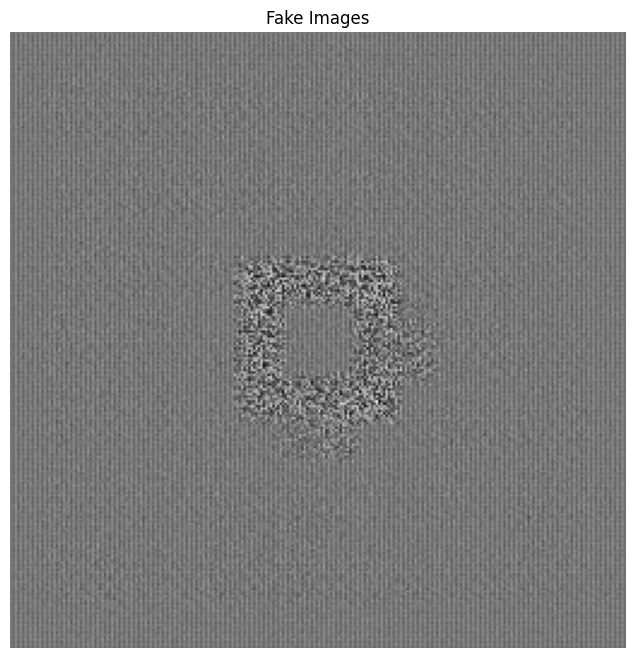

In [234]:

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(vutils.make_grid(fake, padding=2, normalize=True).permute(1, 2, 0))
plt.show()